In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import re
from collections import Counter
from datasets import load_dataset, logging as ds_logging

import spacy
from scispacy.abbreviation import AbbreviationDetector
import nltk;
nltk.download("stopwords", quiet=True)

from wordcloud import WordCloud


In [ ]:
!pip install -r requirements.txt

In [ ]:
import sys
print(sys.executable)

!{sys.executable} -m pip install -U pip setuptools wheel
!{sys.executable} -m pip install -U spacy scispacy
!{sys.executable} -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz

!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install wordcloud

# Load abstracts

In [23]:
RANDOM_STATE     = 42
SAMPLE_N         = 2000        # NUM abstracts 
MIN_TOKENS_DOC   = 20          # drop short docs after cleaning
MIN_DF_ABS       = 10          # absolute min_df for ~600 docs
MAX_DF_FRAC      = 0.55        # prune top ~50% most ubiquitous tokens
PHRASE_MIN_COUNT = 5           # 
PHRASE_THRESHOLD = 5.0         #

np.random.seed(RANDOM_STATE)
ds_logging.set_verbosity_error()

# ---- Load & rebuild abstracts ----
ds = load_dataset("armanc/pubmed-rct20k")
train_df = ds["train"].to_pandas()

abstracts = (train_df.sort_values(["abstract_id", "sentence_id"]).groupby("abstract_id")["text"].apply(lambda s: " ".join(s)).reset_index())

# sample ~N abstracts
abstracts = abstracts.sample(n=SAMPLE_N, random_state=RANDOM_STATE).reset_index(drop=True)

print("shape: " , abstracts.shape)
abstracts

Repo card metadata block was not found. Setting CardData to empty.


shape:  (2000, 2)


abstract_id                                               text
0       25416486  Patient centred and individually-tailored coun...
1       24845394  The steady-state pharmacokinetics of two doses...
2       25651741  NT-pro-BNP level is increased in both systolic...
3       24300949  This study aims to determine the long-term eff...
4       24794277  The aim of this trial was to compare the rates...
...          ...                                                ...
1995    25042995  The root bark of Aralia is a rich source of bi...
1996    25253539  Preliminary findings suggest that Web-based in...
1997    25595231  To provide comparisons and a worked example of...
1998    25165161  Live attenuated influenza vaccine ( LAIV ) and...
1999    26222559  Apolipoprotein C-III ( APOC@ ) is a key regula...

[2000 rows x 2 columns]

In [24]:
# ----  Stoplists & markers (APPLIED AFTER LEMMA) ----
# PubMed/trial boilerplate 
PUBMED_STOP = {
    "study","studies","background","objective","objectives","method","methods",
    "result","results","conclusion","conclusions","introduction","aim","aims",
    "patient","patients","participant","participants","subject","subjects",
    "group","groups","arm","arms","trial","cohort","sample","samples","baseline",
    "randomize","randomised","randomized","double","blind","double-blind","placebo",
    "include","including","perform","performed","report","reported","assess","assessed",
    "measure","measured","analyze","analysis","analyses","associate","associated",
    "increase","increased","decrease","decreased","rate","rates",
    "week","weeks","month","months","year","years","daily","usual",
    "based","level","levels","score","scores","change","changes","clinical","life",
    "respectively","data","follow","follow-up","difference","differences","receive","received",
    "effect","effects","primary","event","events","quality","safety","reduction","phase", 
    "used", "use", "using", "versus", "found", "however", "similar", "observed", "number", "total", 
    "first", "without", "based", "conducted", "associated", "associations", "characteristics", "factors", "statistically"
}



# Generic glue (lemma forms). We target bare verbs/nouns you flagged.
GLUE_STOP = {
    "this","that","there","from","over","either","only","but","most","into","under",
    "who","have","had","do","did","they","those","among","also","when","per",
    "than","more","both","each","all","will","be","are","is","been","after","before",
    "during","between","time","day","days","mean","range","two"
}

# Domain-generic process verbs/nouns (lemma) you don’t want as anchors
DOMAIN_GLUE = {
    "compare", "compared", "control","significant","significantly","test","find","program",
    "effective","effectiveness","intervention","interventions","outcome","outcomes",
    "assign","randomly","evaluate","assess","measure","analyze","detect","improve","improvement"
}

# Dataset bracket/marker junk
MARKER_TOKENS = {
    "-lsb-","-rsb-","-lrb-","-rrb-","-lsqb-","-rsqb-","lsb","rsb","lrb","rrb","lsqb","rsqb"
}

# tokens to drop if they contain digits or start with a hyphen (e.g., -mm, -week)
def _bad_token(tok: str) -> bool:
    return any(ch.isdigit() for ch in tok) or tok.startswith("-")

# Tokenization

In [25]:
# ---- Tokenization + Lemmatization with stopwording ----
# allow letters, hyphen, underscore (underscore marks phrases)
_WORD_RE = re.compile(r"[a-z\-_]+")

def tokenize_docs(texts):
    # marker/bracket junk to drop
    base_stop = set(MARKER_TOKENS)

    # English stopwords
    from nltk.corpus import stopwords as _sw
    en_sw = set(_sw.words("english"))

    # scispaCy model + abbreviation detector (assumes spacy + scispacy installed)
    print("Loading en_core_sci_md ...")
    nlp = spacy.load("en_core_sci_md", disable=["ner", "textcat"])
    nlp.add_pipe("abbreviation_detector")
    print("Loaded en_core_sci_md OK.")

    out = []
    for doc in nlp.pipe(texts, batch_size=64):
        # expand abbreviations (e.g., "BP" -> "blood pressure")
        abbr_map = {str(abbr): str(abbr._.long_form) for abbr in doc._.abbreviations}
        txt = doc.text
        for abbr, longf in abbr_map.items():
            txt = re.sub(rf"\b{re.escape(abbr)}\b", longf, txt, flags=re.IGNORECASE)

        # tokenize + lemmatize (no NER/textcat for speed)
        d2 = nlp.make_doc(txt)

        toks_lemma = []
        for t in d2:
            s = (t.lemma_ or t.text).lower()

            # keep only a-z / hyphen / underscore tokens
            if not _WORD_RE.fullmatch(s):
                continue

            # length + stopword + junk filters
            if len(s) < 3:
                continue
            if s in en_sw:
                continue
            if s in base_stop or _bad_token(s):
                continue

            toks_lemma.append(s)

        # remove PubMed boilerplate + generic/domain glue
        toks = [
            w for w in toks_lemma
            if w not in PUBMED_STOP and w not in GLUE_STOP and w not in DOMAIN_GLUE
        ]
        out.append(toks)

    return out


tokenized = tokenize_docs(abstracts["text"].tolist())
tokenized = [tl for tl in tokenized if len(tl) >= MIN_TOKENS_DOC]

tokenized

Loading en_core_sci_md ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


Loaded en_core_sci_md OK.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scispacy/abbreviation.py:248: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  global_matches = self.global_matcher(doc)


[['centred',
  'individually-tailored',
  'counselling',
  'older',
  'people',
  'chronic',
  'condition',
  'live',
  'home',
  'useful',
  'support',
  'independence',
  'paper',
  'presents',
  'development',
  'psychometric',
  'testing',
  'apn-bq',
  'instrument',
  'patient-centeredness',
  'in-home',
  'counselling',
  'questionnaire',
  'developed',
  'tested',
  'people',
  'older',
  'principal',
  'component',
  'varimax',
  'rotation',
  'revealed',
  'four',
  'factor',
  'model',
  'scoring',
  'items',
  'loaded',
  'cronbach',
  'alpha',
  'utility',
  'acceptance',
  'instrument',
  'confirmed',
  'high',
  'response',
  'fact',
  'answered',
  'questions',
  'apn-bq',
  'shown',
  'reliable',
  'instrument',
  'good',
  'content',
  'construct',
  'validity',
  'tool',
  'apns',
  'structure',
  'process',
  'patient-centred',
  'individually-tailored',
  'counselling',
  'degree',
  'participation',
  'empowerment'],
 ['steady-state',
  'pharmacokinetics',
  'doses

In [ ]:
# ----  Phrase mining (bi -> tri), tuned for  docs ----
try:
    from gensim.models.phrases import Phrases, Phraser

    # learn bigrams
    big = Phrases( tokenized,  min_count=PHRASE_MIN_COUNT, threshold=PHRASE_THRESHOLD,  delimiter="_")
    big_p = Phraser(big)

    # APPLY using [] not ()
    tokenized = [big_p[tl] for tl in tokenized]

    # learn trigrams
    tri = Phrases(tokenized, min_count=PHRASE_MIN_COUNT, threshold=PHRASE_THRESHOLD, delimiter="_")
    tri_p = Phraser(tri)

    # APPLY using [] not ()
    tokenized = [tri_p[tl] for tl in tokenized]
    print("Phrase mining OK (bi → tri)")

except Exception as e:
    print("Phrase mining failed:", e)

# ----  hard-seed important biomedical phrases ----
MUST_PHRASES = [
    ("blood", "pressure"), ("weight", "loss"),("hazard", "ratio"),
    ("odds", "ratio"), ("overall", "survival"), ("progression-free", "survival"),
    ("adverse", "events"), ("ejection", "fraction"), ("knee", "pain"),
    ("viral", "load"), ("cd4", "count"), ("smoking", "cessation"),
]

for tl in tokenized:
    j = 0
    while j < len(tl) - 1:
        if (tl[j], tl[j+1]) in MUST_PHRASES:
            tl[j:j+2] = [tl[j] + "_" + tl[j+1]]
        else:
            j += 1

Phrase mining OK (bi → tri)


In [27]:
# ----  Document-frequency filtering (no top-N cap) ----
D_pre = len(tokenized)
df = Counter()
for tl in tokenized:
    df.update(set(tl))

min_df = max(MIN_DF_ABS, 1)
max_df = int(MAX_DF_FRAC * D_pre)
keep = {w for w, c in df.items() if (c >= min_df and c <= max_df)}

tokenized = [[w for w in tl if w in keep] for tl in tokenized]

# rebuild vocab (stable order)
vocab_list = sorted(keep)
vocab = {w: i for i, w in enumerate(vocab_list)}
i2word = {i: w for w, i in vocab.items()}

print(f"Docs after cleaning: {len(tokenized)} | Vocab size: {len(vocab)} | min_df={min_df}, max_df={max_df}")

Docs after cleaning: 2000 | Vocab size: 2647 | min_df=10, max_df=1100


In [28]:
# ----  Build words/docs for your Gibbs  ----
words, docs = [], []
for doc_id, doc in enumerate(tokenized):
    for w in doc:
        if w in vocab:
            words.append(vocab[w])
            docs.append(doc_id)

words = np.array(words, dtype=int)
docs  = np.array(docs,  dtype=int)

D = int(docs.max()) + 1 if docs.size else 0
W = int(words.max()) + 1 if words.size else 0
N = len(docs)

print(f"#docs={D}, vocab size={W}, total tokens={N}")

# (Optional quick sanity)
for i in range(min(2, len(tokenized))):
    print("Sample tokens:", tokenized[i][:25])

#docs=2000, vocab size=2647, total tokens=126840
Sample tokens: ['older_people', 'chronic', 'condition', 'live', 'home', 'useful', 'support', 'paper', 'development', 'testing', 'instrument', 'questionnaire', 'developed', 'tested', 'people', 'older', 'component', 'revealed', 'four', 'factor', 'model', 'scoring', 'items', 'utility', 'acceptance']
Sample tokens: ['pharmacokinetics', 'doses', 'investigated', 'application', 'two-way', 'cross-over', 'seven', 'healthy', 'postmenopausal_women', 'age', 'allocated', 'applied', 'upper', 'serum', 'sex', 'metabolite', 'concentrations', 'serum', 'pharmacokinetic_parameters', 'cmax', 'calculated', 'standard', 'approach', 'single-dose', 'application']


In [29]:
# Initialize our latent assignments Z and set up per-X-topic arrays to keep track of assignment totals

np.random.seed(0)

# T = 5        # Only two topics ("HCI" and "Graph theory")
# beta = .01     # LDA parameters: control sparsity of documents & topics
# alpha = .001

T = 20
beta = 0.07
alpha = 0.1

a = np.zeros((D,T),dtype=int)   # total times a token in document d has been assigned to topic t
b = np.zeros((W,T),dtype=int)   # total times word w has been assigned to topic t
c = np.zeros((T,),dtype=int)    # total assignments to topic t

z = np.random.randint(T,size=N);  # assign every token to a topic at random
for n in range(N):
    a[docs[n],z[n]] += 1             # and each document ID
    b[words[n],z[n]] += 1             # count up number for each word ID
    c[z[n]] += 1

In [30]:
# Code borrowed from Alexander Ihler
def gibbs_collapsed(maxIter):
    for it in range(maxIter):             # for each iteration 
        if it%100 ==0 : print(it)
        for i in range(N):                # run through all the words & sample z[i]:
            t = z[i];
            a[docs[i],t] -= 1                # remove token i's assignment from our count vectors
            b[words[i],t] -= 1            
            c[t]      -= 1

            # Compute topic probability distribution given current counts
            probs = (beta + b[words[i],:])/(c[:] + beta*W) * (alpha + a[docs[i],:])

            # Now, normalize and draw a sample from the distribution over topics:
            cumprobs = np.cumsum(probs); cumprobs /= cumprobs[-1] 
            t = np.where(cumprobs>np.random.rand())[0][0]

            z[i] = t;                      # now add this assignment back into our count vectors
            a[docs[i],t] += 1
            b[words[i],t] += 1
            c[t]      += 1

In [31]:
# Helper function for visualizing the learning process
def print_topics():
    '''Print the top 8 words in each topic given the current assignments'''
    for t in range(T):
        isort = np.argsort(-b[:,t])  # find the most likely words for topic t
        xsort = b[isort,t]           # then print topic, % tokens explained, & top 8 words
        print('[{}] ({:.3f}) {}'.format(t, 1.*c[t]/N, list(i2word[isort[ww]] for ww in range(8) if xsort[ww]>0)))

In [32]:
print_topics();       # before running any iterations: random assignment

[0] (0.049) ['treatment', 'lower', 'higher', 'pain', 'therapy', 'care', 'may', 'efficacy']
[1] (0.050) ['treatment', 'lower', 'efficacy', 'therapy', 'higher', 'care', 'treated', 'pain']
[2] (0.049) ['treatment', 'lower', 'higher', 'one', 'may', 'efficacy', 'pain', 'therapy']
[3] (0.051) ['treatment', 'efficacy', 'risk', 'therapy', 'three', 'higher', 'may', 'surgery']
[4] (0.051) ['treatment', 'therapy', 'women', 'higher', 'risk', 'efficacy', 'pain', 'one']
[5] (0.050) ['treatment', 'therapy', 'higher', 'may', 'lower', 'following', 'pain', 'women']
[6] (0.051) ['treatment', 'women', 'dose', 'higher', 'efficacy', 'care', 'showed', 'different']
[7] (0.050) ['treatment', 'therapy', 'risk', 'may', 'response', 'lower', 'care', 'efficacy']
[8] (0.050) ['treatment', 'efficacy', 'pain', 'one', 'therapy', 'adverse', 'treated', 'reduced']
[9] (0.050) ['treatment', 'higher', 'may', 'pain', 'efficacy', 'therapy', 'lower', 'showed']
[10] (0.049) ['treatment', 'efficacy', 'pain', 'risk', 'therapy', '

# collapsed gibbs sampling

In [36]:
gibbs_collapsed(500)            # run a bunch of iterations
print_topics();

0
100
200
300
400
[0] (0.065) ['surgery', 'postoperative', 'surgical', 'complications', 'procedure', 'pain', 'undergoing', 'operation']
[1] (0.045) ['serum', 'plasma', 'concentrations', 'vitamin', 'inflammation', 'urinary', 'c-reactive_protein', 'protein']
[2] (0.041) ['volume', 'pressure', 'heart', 'index', 'blood_pressure', 'response', 'low', 'higher']
[3] (0.052) ['men', 'alcohol', 'risk', 'association', 'smoking', 'lower', 'age', 'response']
[4] (0.049) ['exercise', 'training', 'experimental', 'functional', 'exercises', 'walking', 'rehabilitation', 'muscle']
[5] (0.029) ['women', 'pregnancy', 'infants', 'screening', 'delivery', 'postpartum', 'lower', 'maternal']
[6] (0.052) ['treatment', 'pain', 'efficacy', 'acupuncture', 'syndrome', 'symptoms', 'cases', 'symptom']
[7] (0.048) ['eyes', 'conventional', 'one', 'showed', 'evaluated', 'better', 'treated', 'application']
[8] (0.040) ['children', 'vaccine', 'one', 'assigned', 'parents', 'asthma', 'age', 'child']
[9] (0.073) ['care', 'adh

# coherence evaluation

In [ ]:
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

def get_topics_from_counts(b, i2word, T, topn=10):
    """
    Extract top-n words per topic from Gibbs word-topic count matrix b (W x T).
    Returns: List[List[str]] topics
    """
    topics = []
    for t in range(T):
        # sort words by count in topic t (descending)
        isort = np.argsort(-b[:, t])
        # map top indices -> words (skip zero-count words)
        top_words = []
        for idx in isort:
            if b[idx, t] <= 0:
                break
            top_words.append(i2word[int(idx)])
            if len(top_words) >= topn:
                break
        topics.append(top_words)
    return topics

def coherence_scores(tokenized, b, i2word, T, topn=10, metrics=("c_v", "c_npmi")):
    """
    Compute coherence for given metrics.
    tokenized: List[List[str]] (your processed docs)
    b: np.array shape (W, T)
    i2word: dict {id:int -> word:str}
    """
    # build gensim dictionary & corpus
    dictionary = Dictionary(tokenized)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized]

    # topics from your Gibbs counts
    topics = get_topics_from_counts(b, i2word, T, topn=topn)

    results = {}
    for m in metrics:
        cm = CoherenceModel(
            topics=topics,
            texts=tokenized,
            corpus=corpus,
            dictionary=dictionary,
            coherence=m
        )
        results[m] = cm.get_coherence()  # average across topics
    return topics, results

# ---- 
topics, scores = coherence_scores(
    tokenized=tokenized,
    b=b,
    i2word=i2word,
    T=T,
    topn=10,                    # top words per topic used for coherence
    metrics=("c_v", "c_npmi")   # start with c_v; npmi is optional but nice
)

print("Coherence scores:")
for k, v in scores.items():
    print(f"  {k}: {v:.4f}")

# per-topic coherence 
def per_topic_coherence(tokenized, topics, metric="c_v"):
    dictionary = Dictionary(tokenized)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized]
    cm = CoherenceModel(
        topics=topics,
        texts=tokenized,
        corpus=corpus,
        dictionary=dictionary,
        coherence=metric
    )
    return cm.get_coherence_per_topic()

c_v_per_topic = per_topic_coherence(tokenized, topics, metric="c_v")
print("\nPer-topic c_v :")
for t, sc in list(enumerate(c_v_per_topic))[:20]:
    print(f"  Topic {t:2d}: {sc:.4f} | {topics[t]}")


Coherence scores:
  c_v: 0.5538
  c_npmi: 0.0403

Per-topic c_v :
  Topic  0: 0.7046 | ['surgery', 'postoperative', 'surgical', 'complications', 'procedure', 'pain', 'undergoing', 'operation', 'lower', 'incidence']
  Topic  1: 0.6601 | ['serum', 'plasma', 'concentrations', 'vitamin', 'inflammation', 'urinary', 'c-reactive_protein', 'protein', 'concentration', 'urine']
  Topic  2: 0.3675 | ['volume', 'pressure', 'heart', 'index', 'blood_pressure', 'response', 'low', 'higher', 'peak', 'oxygen']
  Topic  3: 0.5033 | ['men', 'alcohol', 'risk', 'association', 'smoking', 'lower', 'age', 'response', 'smokers', 'relationship']
  Topic  4: 0.6572 | ['exercise', 'training', 'experimental', 'functional', 'exercises', 'walking', 'rehabilitation', 'muscle', 'sessions', 'motor']
  Topic  5: 0.6113 | ['women', 'pregnancy', 'infants', 'screening', 'delivery', 'postpartum', 'lower', 'maternal', 'less', 'neonatal']
  Topic  6: 0.5956 | ['treatment', 'pain', 'efficacy', 'acupuncture', 'syndrome', 'sympto

# word cloud

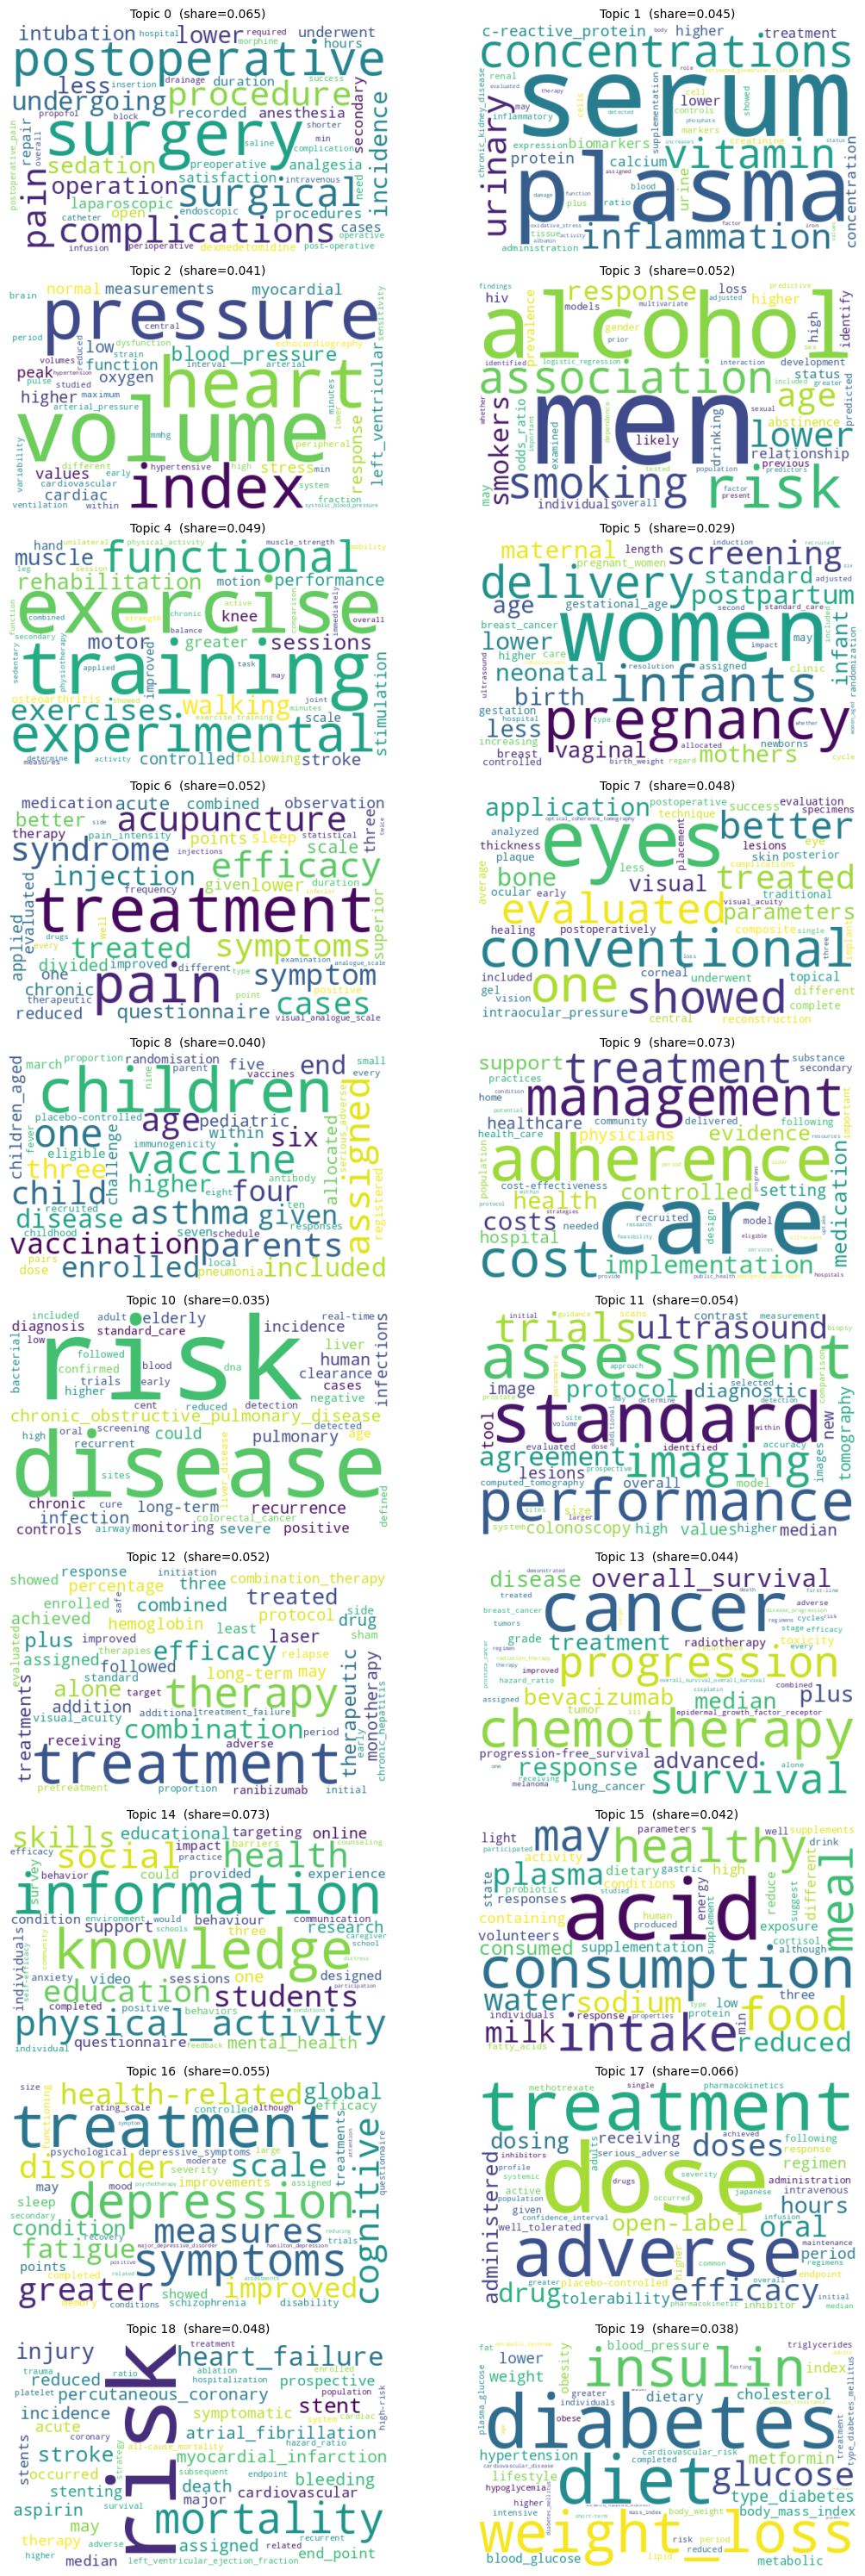

In [ ]:
def show_topic_wordcloud(t, topn=50, use_smoothed=True):
    """
    Draw wordcloud for topic t 
    t: topic index
    topn: how many words to include in the cloud
    use_smoothed: if True uses (b + beta) weights; else uses raw counts b
    """
    weights = b[:, t].astype(float)
    if use_smoothed:
        weights = weights + beta

    idx = np.argsort(weights)[::-1][:topn]
    freqs = {i2word[i]: float(weights[i]) for i in idx if weights[i] > 0}

    wc = WordCloud(
        width=500,
        height=300,
        background_color="white",
        collocations=False,
        prefer_horizontal=0.9
    ).generate_from_frequencies(freqs)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {t}  (share={c[t]/N:.3f})", fontsize=10)


cols = 2
rows = 10
plt.figure(figsize=(cols*6, rows*3))

for t in range(T):
    plt.subplot(rows, cols, t+1)
    show_topic_wordcloud(t, topn=50, use_smoothed=True)

plt.tight_layout()
plt.show()


# Topic–Word Bar Charts

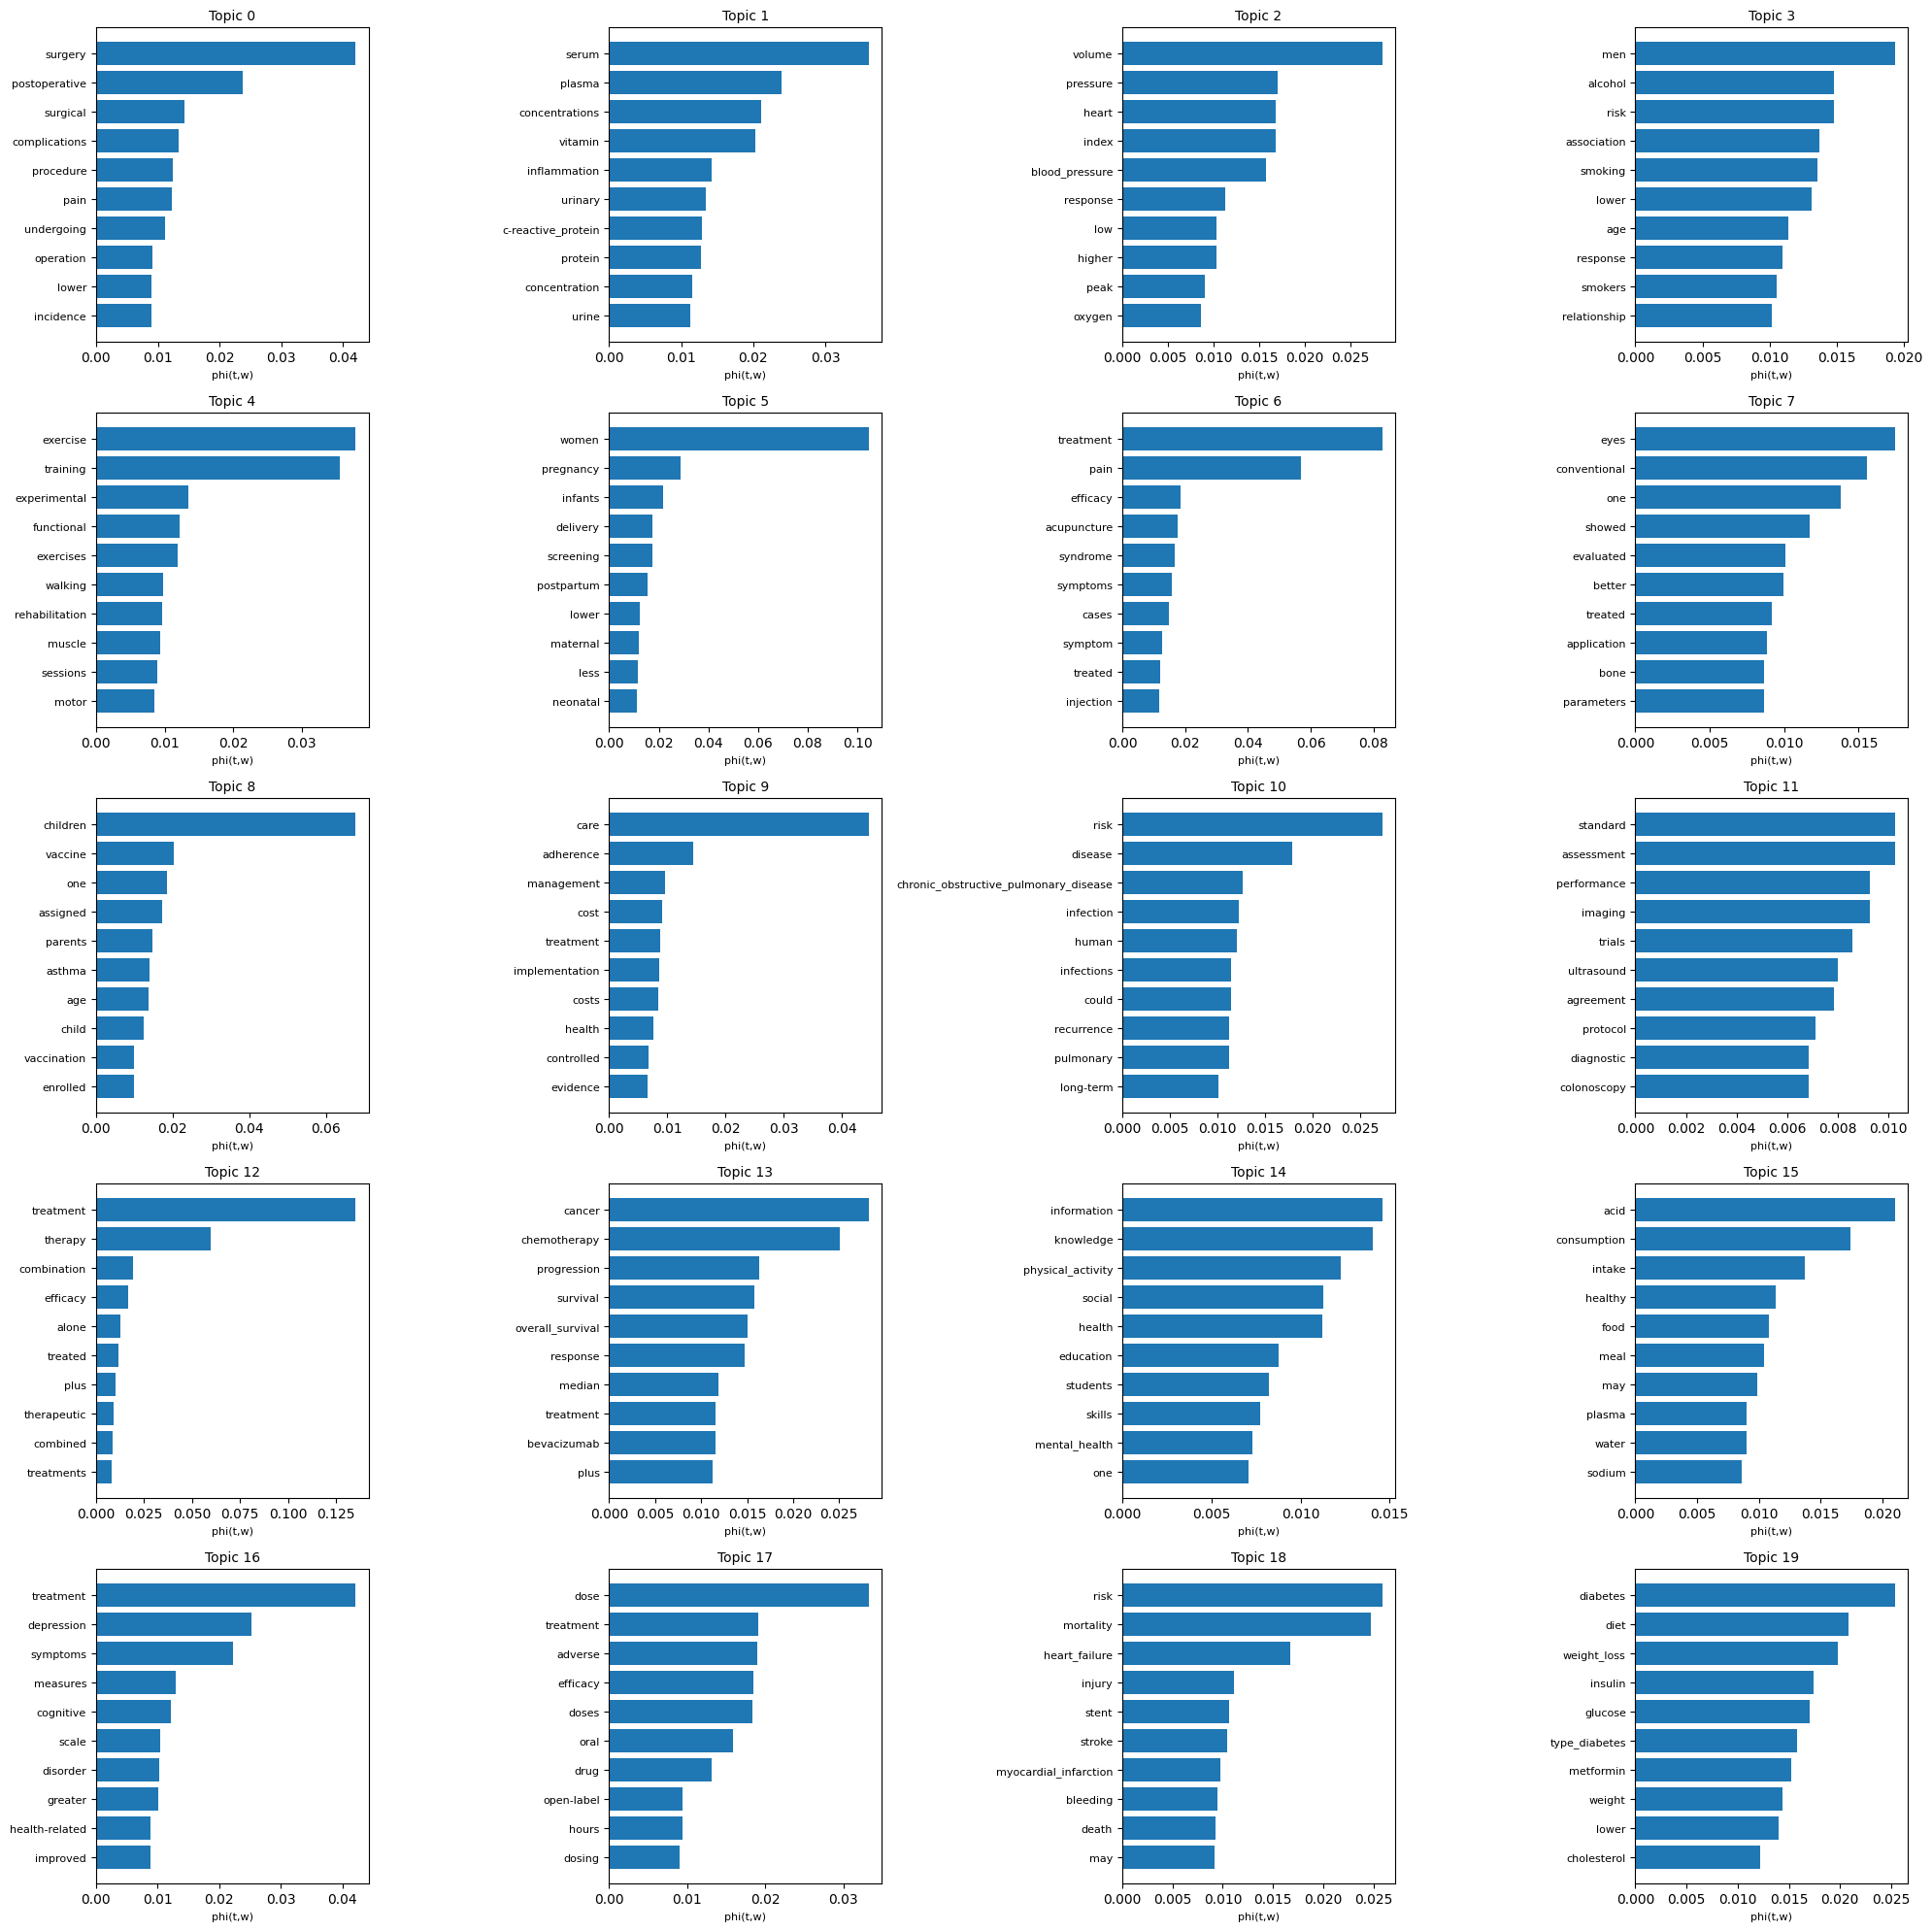

In [ ]:
def topic_word_barchart(t, topn=10, use_phi=True):
    counts = b[:, t].astype(float)

    if use_phi:
        denom = (c[t] + beta * W)
        weights = (counts + beta) / denom if denom > 0 else (counts + beta)
        xlab = "phi(t,w)"
    else:
        weights = counts
        xlab = "count"

    idx = np.argsort(weights)[::-1][:topn]
    words_top = [i2word[int(i)] for i in idx]
    w_top = weights[idx]

    plt.barh(range(topn), w_top[::-1])
    plt.yticks(range(topn), words_top[::-1], fontsize=8)
    plt.xlabel(xlab, fontsize=8)
    plt.title(f"Topic {t}", fontsize=10)


# --- grid wrapper ---
cols = 4
rows = int(np.ceil(T / cols))

plt.figure(figsize=(cols*5, rows*4))

for t in range(T):
    plt.subplot(rows, cols, t+1)
    topic_word_barchart(t, topn=10, use_phi=True)

plt.tight_layout()
plt.show()
